<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fft_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: implement fft in 3D like `compSPI.transforms`

In [11]:
import torch
from scipy import signal
import matplotlib.pyplot as plt
from torch import tensor
def doplt(arr2d): 
  return plt.imshow(arr2d,cmap='gray')

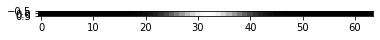

In [98]:
n_pix=64
window = tensor(signal.gaussian(n_pix+1, std=5))[:-1]
doplt(window.reshape(1,-1))

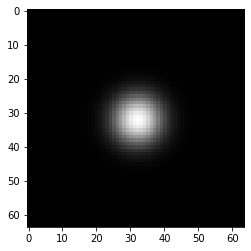

In [99]:
g_2d = window.reshape(1,-1) * window.reshape(-1,1) #torch.outer(window,window) #
doplt(g_2d)

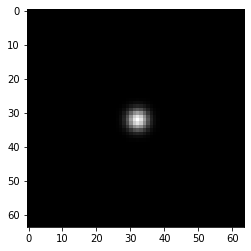

In [100]:
def primal_to_fourier_2D(r):
    """Return fourier transform of a batch of image.
    Parameters
    ----------
    r: torch.Tensor
        Tensor of size (batch,1, size,size)
    Returns
    -------
    out: torch.Tensor
        Tensor of size (batch,1, size,size)
    """
    r = torch.fft.fftshift(r, dim=(-2, -1))
    return torch.fft.ifftshift(
        torch.fft.fftn(r, s=(r.shape[-2], r.shape[-1]), dim=(-2, -1)), dim=(-2, -1)
    )

g_2d_f = primal_to_fourier_2D(g_2d)
doplt(g_2d_f.real)

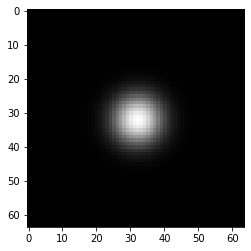

In [101]:
#g_3d = g_2d.reshape(n_pix,n_pix,1) * g_2d.reshape(1,n_pix,n_pix)
g_3d = window.reshape(-1,1,1) * window.reshape(1,-1,1) * window.reshape(1,1,-1) 
  # works but just different scale!
  # and at tails very close because small different in tails
doplt(g_3d[n_pix//2])

3D FFT

In [123]:
r = g_3d.reshape(1,1,n_pix,n_pix,n_pix)
r_shift = torch.fft.fftshift(r, dim=(-3, -2, -1))

f_shift = torch.fft.fftn(r_shift, s=(r.shape[-3], r.shape[-2], r.shape[-1]), dim=(-3, -2, -1))

f = torch.fft.ifftshift(f_shift, dim=(-3, -2, -1))



In [124]:
f.real.abs().sum(), f.imag.abs().sum()

(tensor(262144.0004, dtype=torch.float64),
 tensor(2.2277e-10, dtype=torch.float64))

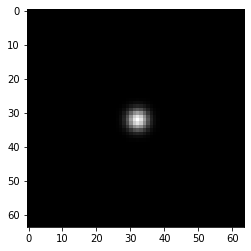

In [125]:
doplt(f.real[0,0,n_pix//2])



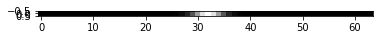

In [126]:
doplt(f.real.sum(dim=(0,1,2,3)).reshape(1,-1))

In [127]:
def primal_to_fourier_3D(r):
    """Return fourier transform of a batch of image.
    Parameters
    ----------
    r: torch.Tensor
        Tensor of size (batch, size, size, size)
    Returns
    -------
    out: torch.Tensor
        Tensor of size (batch, size, size, size)
    """
    r = torch.fft.fftshift(r, dim=(-3, -2, -1))
    return torch.fft.ifftshift(
        torch.fft.fftn(r, s=(r.shape[-3], r.shape[-2], r.shape[-1]), dim=(-3, 2, -1)), dim=(-3, -2, -1)
    )

def fourier_to_primal_3D(f):
    """Return inverse fourier transform of a batch of image.
    Parameters
    ----------
    f: torch.Tensor
        Tensor of size (batch,size,size,size)
    Returns
    -------
    out: torch.Tensor
        Tensor of size (batch,size,size,size)
    """
    f = torch.fft.ifftshift(f, dim=(-3, -2, -1))
    return torch.fft.fftshift(
        torch.fft.ifftn(f, s=(f.shape[-3], f.shape[-2], f.shape[-1]), dim=(-3, -2, -1)), dim=(-3, -2, -1)
    )



In [117]:
def test_primal_to_fourier_3D():
    """Test if the fourier transform is correct.
    For this we check if the fourier transform of delta and constant images are
    constant and delta, respectively.
    """
    for size in [50]:

        im = torch.zeros(2, size, size, size)
        im[0, size // 2, size // 2, size // 2] = 1
        im[1, :, :, :] = 1

        im_fourier = primal_to_fourier_3D(im)

        expected_im_fourier = torch.zeros(2, size, size, size)
        expected_im_fourier[0] = im[1] * im[0].sum()
        expected_im_fourier[1] = im[0] * im[1].sum()

        error = (
            expected_im_fourier - im_fourier
        ).abs().sum() / expected_im_fourier.abs().sum()

        assert error < 0.01

In [131]:
def test_fourier_to_primal_3D():
    """Test if the inverse fourier transform is correct.
    For this we check if the fourier transform of delta and constant images are
    constant and delta, respectively.
    """
    for size in [50]:
        im_fourier = torch.zeros(2, 1, size, size, size)
        im_fourier[0, 0, size // 2, size // 2, size // 2] = 1
        im_fourier[1, 0, :, :, :] = 1

        im = fourier_to_primal_3D(im_fourier)

        expected_im = torch.zeros(2, 1, size, size, size)
        expected_im[0] = im_fourier[1] / size**3
        expected_im[1] = im_fourier[0]

        error = (expected_im - im).abs().sum() / expected_im.abs().sum()
        assert error < 0.01

test_fourier_to_primal_3D()